In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Prepare Data

In [5]:
raw_data = pd.read_csv('data.csv')

In [123]:
raw_data.head(3)

,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,ticker,index_flag,issuer,exercise_style
0,2018-01-02,AMZN 180105C1000000,2018-01-05,2017-12-29,C,1000000,189.35,190.6,0,0.962943,118189007,NaN,AMZN,0,AMAZON.COM INC.,A
1,2018-01-02,AMZN 180105C1002500,2018-01-05,NaN,C,1002500,186.85,188.1,0,0.951017,118541021,NaN,AMZN,0,AMAZON.COM INC.,A
2,2018-01-02,AMZN 180105C1005000,2018-01-05,NaN,C,1005000,184.35,185.6,0,0.939104,118541022,NaN,AMZN,0,AMAZON.COM INC.,A


In [6]:
raw_data['exercise_style'].unique()

array(['A'], dtype=object)

In [13]:
df = raw_data[['ticker','date','exdate','cp_flag','volume','strike_price','best_bid','best_offer']].copy()
df['date'] = pd.to_datetime(raw_data['date'])
df['exdate'] = pd.to_datetime(raw_data['exdate'])
df['strike_price'] = raw_data['strike_price']/1000 # scaling strike
df['option_price'] = raw_data[['best_bid','best_offer']].mean(axis=1)
df = df.drop(columns = ['best_bid','best_offer'])

In [15]:
df.head(3)

,ticker,date,exdate,cp_flag,volume,strike_price,option_price
0,AMZN,2018-01-02,2018-01-05,C,0,1000.0,189.975
1,AMZN,2018-01-02,2018-01-05,C,0,1002.5,187.475
2,AMZN,2018-01-02,2018-01-05,C,0,1005.0,184.975


In [17]:
tickers = df['ticker'].unique()
tickers

array(['AMZN', 'JPM', 'JNJ', 'MSFT', 'PG', 'WMT', 'GOOGL', 'V', 'TSLA'],
      dtype=object)

In [18]:
t0 = df['date'].unique()
t0

<DatetimeArray>
['2018-01-02 00:00:00', '2018-01-03 00:00:00', '2018-01-04 00:00:00',
 '2018-01-05 00:00:00', '2018-01-08 00:00:00', '2018-01-09 00:00:00',
 '2018-01-10 00:00:00', '2018-01-11 00:00:00', '2018-01-12 00:00:00',
 '2018-01-16 00:00:00',
 ...
 '2022-12-16 00:00:00', '2022-12-19 00:00:00', '2022-12-20 00:00:00',
 '2022-12-21 00:00:00', '2022-12-22 00:00:00', '2022-12-23 00:00:00',
 '2022-12-27 00:00:00', '2022-12-28 00:00:00', '2022-12-29 00:00:00',
 '2022-12-30 00:00:00']
Length: 1259, dtype: datetime64[ns]

### 2. Combine put and call with same ticker, date, exdate, strike price

In [19]:
call_df = df[df['cp_flag']=='C'].reset_index(drop=True)
put_df = df[df['cp_flag']=='P'].reset_index(drop=True)

In [20]:
mdf =  pd.merge(call_df, put_df, on=['ticker','date','exdate','strike_price'], how='left',suffixes=('_c', '_p'))
mdf = mdf.drop(columns=['cp_flag_c','cp_flag_p'])
mdf

,ticker,date,exdate,volume_c,strike_price,option_price_c,volume_p,option_price_p
0,AMZN,2018-01-02,2018-01-05,0,1000.0,189.975,8.0,0.025
1,AMZN,2018-01-02,2018-01-05,0,1002.5,187.475,0.0,0.080
2,AMZN,2018-01-02,2018-01-05,0,1005.0,184.975,0.0,0.050
3,AMZN,2018-01-02,2018-01-05,0,1007.5,182.475,0.0,0.085
4,AMZN,2018-01-02,2018-01-05,0,1010.0,179.975,3.0,0.080
...,...,...,...,...,...,...,...,...
13328412,TSLA,2022-12-30,2025-01-17,5,75.0,71.050,609.0,15.550
13328413,TSLA,2022-12-30,2025-01-17,123,80.0,68.350,19.0,17.525
13328414,TSLA,2022-12-30,2025-01-17,37,85.0,65.725,20.0,19.500
13328415,TSLA,2022-12-30,2025-01-17,33,90.0,63.275,23.0,21.700


In [22]:
stock_price = pd.read_csv('adjusted_stocks.csv')
stock_price_melt = stock_price.melt(id_vars=['date'], var_name='ticker', value_name='S0')
stock_price_melt.date = pd.to_datetime(stock_price_melt.date)
stock_price_melt

,date,ticker,S0
0,2018-01-02,AMZN,1189.010010
1,2018-01-03,AMZN,1204.199982
2,2018-01-04,AMZN,1209.589996
3,2018-01-05,AMZN,1229.140015
4,2018-01-08,AMZN,1246.869965
...,...,...,...
14089,2024-03-18,TSLA,173.800003
14090,2024-03-19,TSLA,171.320007
14091,2024-03-20,TSLA,175.660004
14092,2024-03-21,TSLA,172.820007


In [23]:
smdf =  pd.merge(mdf, stock_price_melt, on=['date','ticker'], how='left')
smdf['T'] = (smdf.exdate - smdf.date).dt.days / 365
smdf 

,ticker,date,exdate,volume_c,strike_price,option_price_c,volume_p,option_price_p,S0,T
0,AMZN,2018-01-02,2018-01-05,0,1000.0,189.975,8.0,0.025,1189.01001,0.008219
1,AMZN,2018-01-02,2018-01-05,0,1002.5,187.475,0.0,0.080,1189.01001,0.008219
2,AMZN,2018-01-02,2018-01-05,0,1005.0,184.975,0.0,0.050,1189.01001,0.008219
3,AMZN,2018-01-02,2018-01-05,0,1007.5,182.475,0.0,0.085,1189.01001,0.008219
4,AMZN,2018-01-02,2018-01-05,0,1010.0,179.975,3.0,0.080,1189.01001,0.008219
...,...,...,...,...,...,...,...,...,...,...
13328412,TSLA,2022-12-30,2025-01-17,5,75.0,71.050,609.0,15.550,123.18000,2.052055
13328413,TSLA,2022-12-30,2025-01-17,123,80.0,68.350,19.0,17.525,123.18000,2.052055
13328414,TSLA,2022-12-30,2025-01-17,37,85.0,65.725,20.0,19.500,123.18000,2.052055
13328415,TSLA,2022-12-30,2025-01-17,33,90.0,63.275,23.0,21.700,123.18000,2.052055


### 3. Regression

#### Use put call parity: $C-P=S_0-Ke^{-rT}$ to compute interest rate $r = \frac{1}{T}\ln(\frac{K}{S_0+P-C})$. 

In [39]:
regression_df = smdf[['date','exdate','strike_price', 'option_price_c','option_price_p', 'T','S0']]
regression_df.columns = ['date','exdate','K','C','P','T','S0']
regression_df = regression_df.dropna(axis=0)
regression_df

,date,exdate,K,C,P,T,S0
0,2018-01-02,2018-01-05,1000.0,189.975,0.025,0.008219,1189.01001
1,2018-01-02,2018-01-05,1002.5,187.475,0.080,0.008219,1189.01001
2,2018-01-02,2018-01-05,1005.0,184.975,0.050,0.008219,1189.01001
3,2018-01-02,2018-01-05,1007.5,182.475,0.085,0.008219,1189.01001
4,2018-01-02,2018-01-05,1010.0,179.975,0.080,0.008219,1189.01001
...,...,...,...,...,...,...,...
13328412,2022-12-30,2025-01-17,75.0,71.050,15.550,2.052055,123.18000
13328413,2022-12-30,2025-01-17,80.0,68.350,17.525,2.052055,123.18000
13328414,2022-12-30,2025-01-17,85.0,65.725,19.500,2.052055,123.18000
13328415,2022-12-30,2025-01-17,90.0,63.275,21.700,2.052055,123.18000


In [40]:
len(regression_df[(regression_df['C'] - regression_df['P'] - regression_df['S0'])>0])/len(regression_df)

2.9336078770147545e-05

#### remove datapoint unsatisfied condition : $C-P < S_0$

In [41]:
regression_df = regression_df[(regression_df['C'] - regression_df['P'])<regression_df['S0']]

#### Regression model : $y = r*x + \epsilon$, where $(x,\, y) = (T,\, \ln(\frac{K}{S_0+P-C}))$

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

regression_df.loc[:,'y'] = np.log(regression_df['K'] / (regression_df['S0'] + regression_df['P'] - regression_df['C']))

X = regression_df[['T']]
y = regression_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)

r_estimate = model.coef_[0]
print(f"Estimated r: {r_estimate}")
print(f'Mean Square Error: {mse}')

Estimated r: 0.02261114599766386
Mean Square Error: 0.014986376970162918
Mean Absolute Percentage Error: 638869466.172107


## 4. modified regression

#### (1) model r as a function of time t  (group by date t0)

In [112]:
def get_IR(regression_df):
    regression_df['y'] = np.log(regression_df['K'] / (regression_df['S0'] + regression_df['P'] - regression_df['C']))
    
    X = regression_df[['T']]
    y = regression_df['y']
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    r_estimate = model.coef_[0]
    return r_estimate

In [113]:
res = regression_df.groupby('date').apply(get_IR)
res

date
2018-01-02    0.038331
2018-01-03    0.038273
2018-01-04    0.039813
2018-01-05    0.039026
2018-01-08    0.038984
                ...   
2022-12-23    0.032973
2022-12-27    0.032952
2022-12-28    0.032954
2022-12-29    0.033885
2022-12-30    0.034466
Length: 1259, dtype: float64

In [114]:
res.mean()

0.02560654881368453

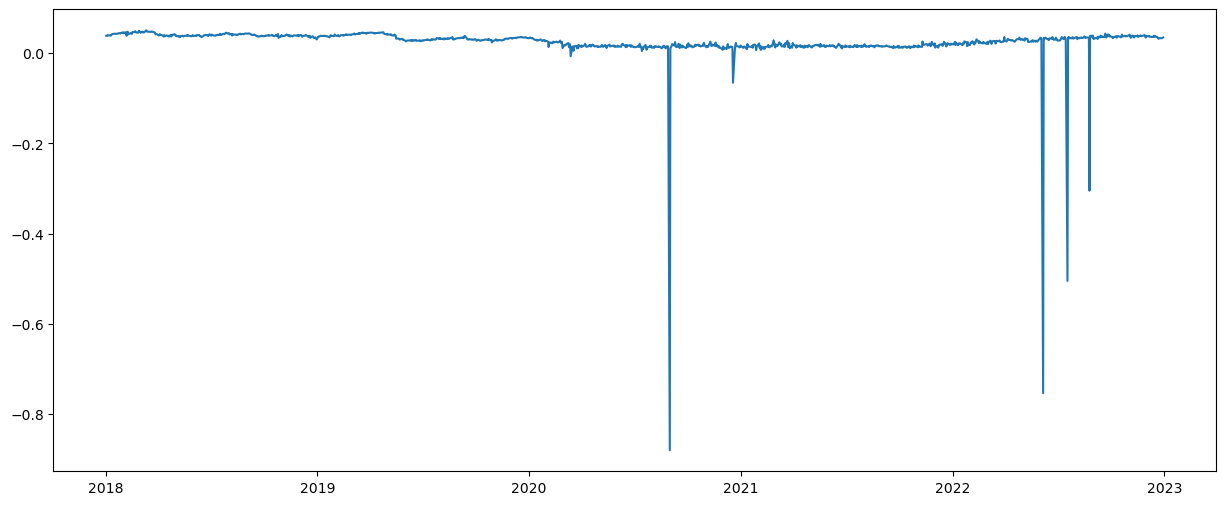

In [115]:
plt.figure(figsize=(15,6))
plt.plot(res)

In [135]:
res[res<0]

exdate
2018-01-19   -1.709486
2019-01-18   -0.040695
2019-08-16   -0.005277
2019-12-20   -0.001214
2020-11-20   -0.003278
2022-06-24   -0.060936
2022-07-01   -0.112660
2022-07-08   -0.365692
2022-07-22   -0.147206
2022-08-05   -0.100902
2022-08-12   -0.227314
2022-08-19   -0.003659
2022-08-26   -0.220166
2022-11-18   -0.001675
dtype: float64

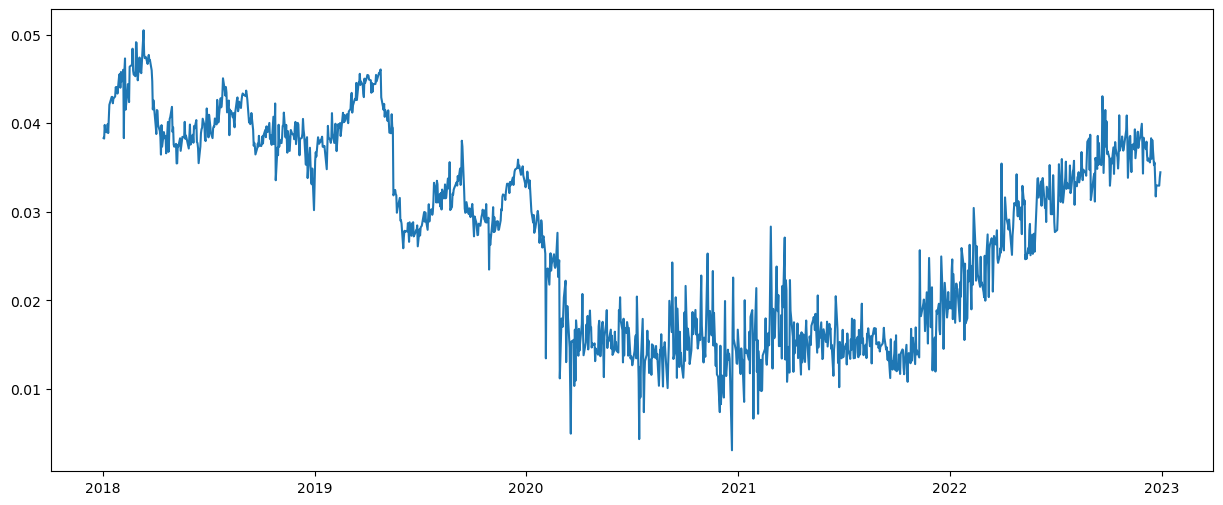

In [117]:
plt.figure(figsize=(15,6))
plt.plot(res[res>=0])

In [116]:
res[res>=0].mean()

0.027737062129895913

### (2) group by maturity (exdate)

In [120]:
res = regression_df.groupby('exdate').apply(get_IR)
res

exdate
2018-01-05    8.331777
2018-01-12    2.579931
2018-01-19   -1.709486
2018-01-26    1.115221
2018-02-02    0.870173
                ...   
2024-01-19    0.019397
2024-03-15    0.027106
2024-06-21    0.027074
2024-09-20    0.039451
2025-01-17    0.034236
Length: 281, dtype: float64

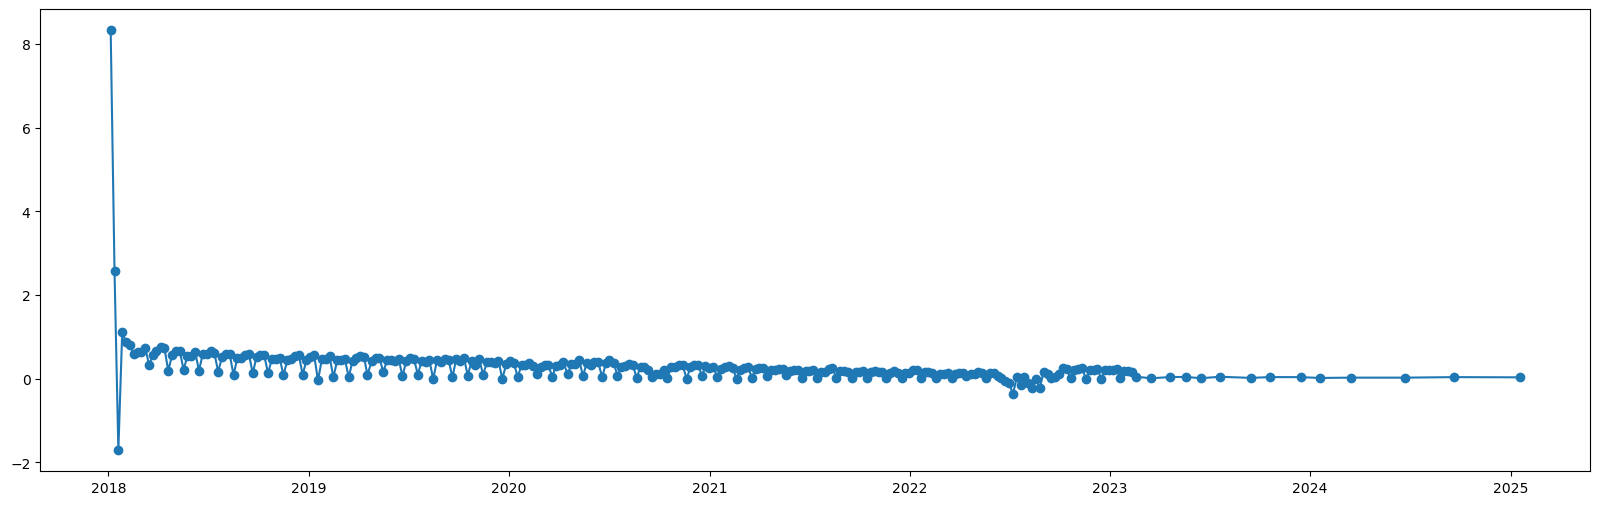

In [122]:
plt.figure(figsize=(20,6))
plt.plot(res, marker='o')

In [121]:
res.iloc[-10:-1]

exdate
2023-06-16    0.014052
2023-07-21    0.047988
2023-09-15    0.021262
2023-10-20    0.040420
2023-12-15    0.038685
2024-01-19    0.019397
2024-03-15    0.027106
2024-06-21    0.027074
2024-09-20    0.039451
dtype: float64